# ☀ Analysis of Brisbane Photovoltaic Installation Data ☀


## Introduction

For this excerise I will take open data on demographic profiles of various suburbs around Brisbane to answer four questions relating to a problem statement. 
The problem statement is:
> Our customer wishes to use this data to understand possible demand for solar panel installations when entering a new region, where counts of installations will not be available but the other factors will be present. This will allow them to focus advertising on suburbs where they are most likely to have a high demand.

The questions are:
1. Please provide a summary and analysis of the factors that you determine to be important for the prediction of the likely number of installations.
2. Please give a description of any surprising findings or spurious factors that you believe may generalize poorly to new regions.
3. Please provide any caveats (or “gotchas”) that you believe may undermine the power of any predictive model developed from these factors.
4. Please outline any data you would wish to augment this dataset with to make a more powerful predictive model or any experiments you would propose to rule out spurious correlations.

I will include a preamble to each question that tries to explain my approach and then I will follow it with analysis and finally by a conclusion and answer.

---

## Import packages and data

In [107]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import re

In [6]:
# Read in data file to dataframe
df = pd.read_excel('Brisbane Suburbs Stats Separated V2.0.xlsx')

---

## Question 1

> Please provide a summary and analysis of the factors that you determine to be important for the prediction of the likely number of installations.

My first thoughts are to understand and categorise the columns in the dataframe.

Relating this back to the problem statement, we should try to reconcile these against different levers that may have an affect on demand for solar panel installations. 

Below are some thoughts for factors that might contribute off the top of my head.
* Economic levers:
    - Financial position of residents
        - Renters
        - Mortgage/owned
        - Employment
            - Salary
    - Construction and real estate
        - New builds
        - Renovations
        - Sales
        - Subsidies? (i.e. are there incentives to build solar panels when building/renovating?)
            - Do these subsidies apply outside of Brisbane/QLD?
    - Electricity usage
    - Proximity to supplier
        - Is this confounded by geography?
* Geographical levers:
    - Weather
    - Altitude
    - Proximity to supplier
* Demographic levers:
    - Do particular demographies have higher demand?
    - Do changing demographies drive demand?
    - Can election results in suburb predict demand for solar? (e.g. do Green's voters install more solar panels?)
    - Penetration in suburb/neighbouring suburb (i.e. does a rising number of solar panels make others consider installation?)
    - Industry of residents
    - Population density

Methods for finding these factors?
|
List some ideas here when I have them to keep track....

Fit plane to ethnicity data?


---

In [55]:
df[pop_cols.union(['Suburb'])]

,Approx km2,Population density (ERP at 30 June) (persons/km2) 2018,Suburb,Total Population (2017)
0,9.722535,1686.7,ALBANY CREEK,16399
1,1.414869,2262.4,ALBION,3201
2,2.414635,2662.1,ALDERLEY,6428
3,13.722610,1232.2,ALEXANDRA HILLS,16909
4,3.639864,2441.3,ALGESTER,8886
...,...,...,...,...
259,25.765147,320.2,"WORONGARY, TALLAI",8250
260,6.066505,2306.6,WYNNUM,13993
261,12.170086,1272.3,"WYNNUM WEST, HEMMANT",15484
262,5.976944,1708.9,"YERONGA, YEERONGPILLY, TENNYSON",10214


In [49]:
# Derive some extra columns
df['Total Population (2017)'] = df[df.columns[5:23]].sum(axis=1)  # I've assumed the age columns capture everyone living in a given suburb
df['Approx km2'] = df['Total Population (2017)']/df['Population density (ERP at 30 June) (persons/km2) 2018']  # Here I've assumed the population has not changed much between 2017 and 2018

In [50]:
# Isolate index and target columns
idx_col           = df.columns[2:3]  # I don't think I need Suburb or Postcode - Just use ABS code as index
target_col        = df.columns[101:102]

# Categorise the columns into different groups
dist_cols         = df.columns[3:5]
age_cols          = df.columns[5:23]
pop_cols          = df.columns[23:24].union(['Total Population (2017)', 'Approx km2'])
ethnicity_cols    = df.columns[24:38]
construction_cols = df.columns[38:42].union(df.columns[113:232])
industry_cols     = df.columns[42:61]    # Rental is included in here?
finance_cols      = df.columns[61:94].union(df.columns[105:113])   # Note: mixture of 2016 and 2018 data in here
housing_cols      = df.columns[94:101]
solar_cols        = df.columns[101:105]  # NOTE: Includes target column

In [3]:
# Create time series with BA data
start = 113
yrs = 17
re_pattern = r'(.*) (\d{4})'

df_time = None

for i in range(7):
    melt_vars = df.columns[start:start+yrs]
    start += yrs  # increment for next iteration
    name = re.search(re_pattern, melt_vars[0])[1]
    col_rename = {
        col: int(re.search(re_pattern, col)[2]) for col in melt_vars
    }
    
    if df_time is None:
        df_time = pd.melt(
            df[idx_col.union(melt_vars)].rename(columns=col_rename),
            id_vars=idx_col,
            var_name='Year',
            value_name=name
        )

    else:
        temp = pd.melt(
            df[idx_col.union(melt_vars)].rename(columns=col_rename),
            id_vars=idx_col,
            var_name='Year',
            value_name=name
        ).set_index(['ABS Code', 'Year'])
        
        df_time = df_time.join(
            temp, 
            on=['ABS Code', 'Year'], 
            how='left'
        )
        
# Add in mean, Q1, median, Q3 for plotting/comparison
df_time_agg = None
agg_label = 'Agg'

# Mean
df_time_agg = df_time.drop(columns=idx_col).groupby('Year').mean().reset_index()
df_time_agg[agg_label] = 'Mean'

# Q1, Median, Q3
temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.25).reset_index()
temp[agg_label] = 'Q1'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.5).reset_index()
temp[agg_label] = 'Median'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.75).reset_index()
temp[agg_label] = 'Q3'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

The cell below is just for testing

In [56]:
# Test to see I captured all columns
all_cols = idx_col.union(target_col)\
    .union(dist_cols).union(age_cols).union(pop_cols).union(ethnicity_cols)\
    .union(construction_cols).union(industry_cols).union(finance_cols).union(housing_cols).union(solar_cols)

# This helps me 
#list(enumerate(df.columns))[:]

# Check I have all columns present and accounted for (I'm ok leaving out Suburb and Postcode)
[(i, col) for i, col in enumerate(df.columns) if col not in all_cols]

[(0, 'Suburb'), (1, 'Postcode ')]

Find correlation using Pearson and Spearman's correlation


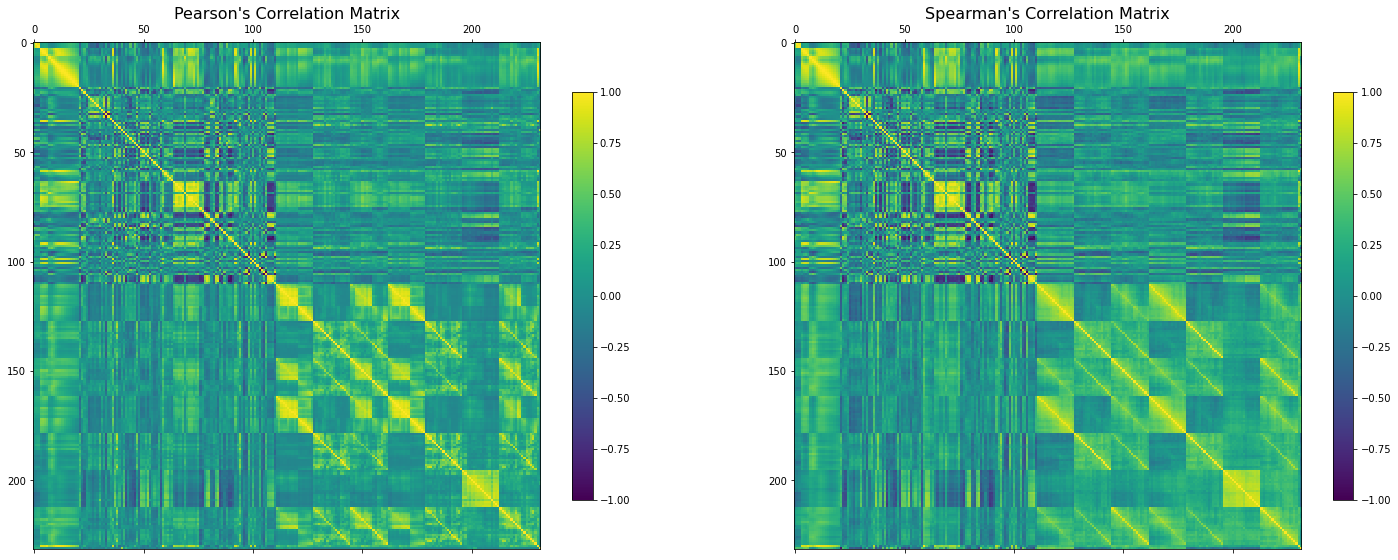

In [170]:
correlation_mat = df.corr(method='pearson')
spearman_mat = df.corr(method='spearman')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.matshow(correlation_mat, fignum=False)
plt.title("Pearson's Correlation Matrix", fontsize=16)

cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params()

plt.subplot(1, 2, 2)
plt.matshow(spearman_mat, fignum=False)
plt.title("Spearman's Correlation Matrix", fontsize=16)

cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params()
plt.show()

There's a lot going on here due to the sheer number of columns, but we can definitely see plenty of dark blue and yellow indicating there is correlation to be found. The blocks in the bottom right are from the time series data which makes sense that they are correlated. Let's take a look at the distribution of these correlation coefficients to see how strong some of them are.

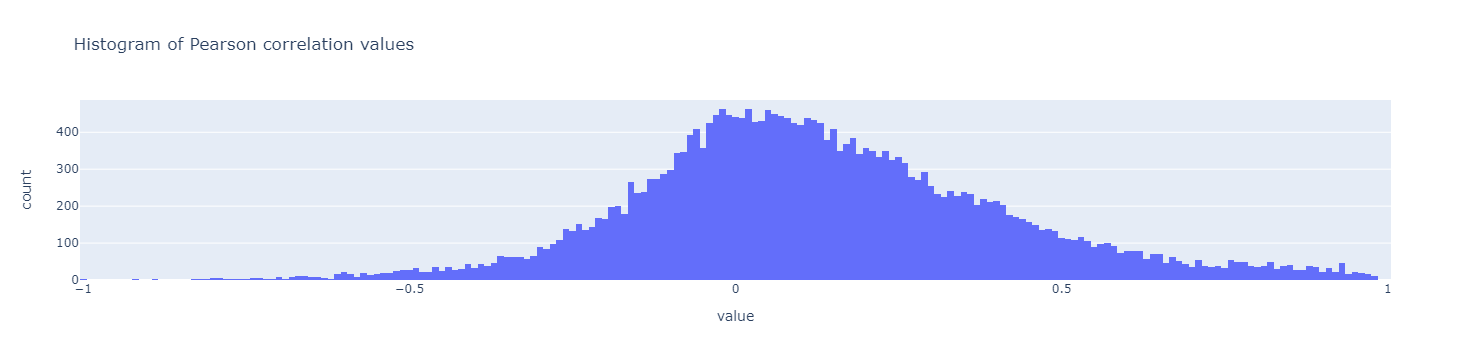

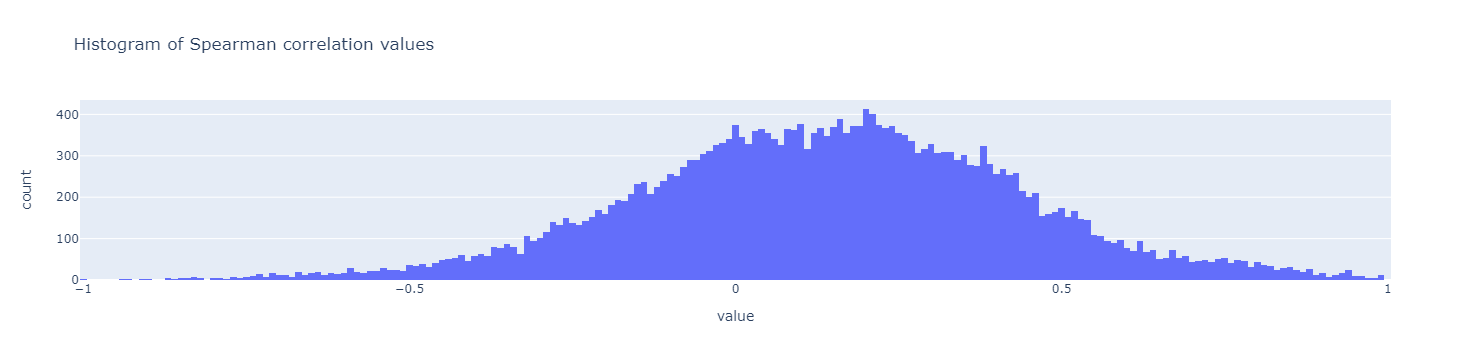

Number of pairs with Pearson correlation in [-1.00, -0.80): 22        Number of pairs with Spearman correlation in [-1.00, -0.80): 49
Number of pairs with Pearson correlation in [-0.80, -0.60): 134       Number of pairs with Spearman correlation in [-0.80, -0.60): 228
Number of pairs with Pearson correlation in [-0.60, -0.40): 494       Number of pairs with Spearman correlation in [-0.60, -0.40): 677
Number of pairs with Pearson correlation in [-0.40, -0.20): 1837      Number of pairs with Spearman correlation in [-0.40, -0.20): 2204
Number of pairs with Pearson correlation in [-0.20, 0.00): 6413       Number of pairs with Spearman correlation in [-0.20, 0.00): 5145
Number of pairs with Pearson correlation in [0.00, 0.20): 8302        Number of pairs with Spearman correlation in [0.00, 0.20): 7142
Number of pairs with Pearson correlation in [0.20, 0.40): 5429        Number of pairs with Spearman correlation in [0.20, 0.40): 6526
Number of pairs with Pearson correlation in [0.40, 0.60):

In [171]:
# Flatten correlation matrix
# Note: only need to count up to the ith element in each row since matrix is symmetric with 1s along the 
#       diagonal which we can exclude (as they offer no insight)
corr_vals = [item for i, row in enumerate(correlation_mat.values.tolist()) for item in row[:i]]
spearman_vals = [item for i, row in enumerate(spearman_mat.values.tolist()) for item in row[:i]]

# Histogram of correlation values to determine what the correlation looks like
# This could be better as a density but I find it more informative as a count
fig = px.histogram(
    corr_vals,
    title='Histogram of Pearson correlation values'
)

fig.update_layout(showlegend=False)
fig.show()

fig = px.histogram(
    spearman_vals,
    title='Histogram of Spearman correlation values',
)

fig.update_layout(showlegend=False)
fig.show()

# This can probably go but I was just interested in seeing the counts
n = 10
for i in range(n):
    lower, upper = 2*i/n - 1, 2*(i+1)/n - 1
    # Print number of pairs in different correlation bands for extra context
    print(
        f"Number of pairs with Pearson correlation in [{lower:0.2f}, {upper:0.2f}): {len([v for v in corr_vals if lower <= v < upper])}".ljust(70) +\
        f"Number of pairs with Spearman correlation in [{lower:0.2f}, {upper:0.2f}): {len([v for v in spearman_vals if lower <= v < upper])}"
    )

print("-"*140)
    
# Just to make sure there are none perfectly correlated
print(
    f"Number of pairs with Pearson correlation == {-1:0.2f}: {len([v for v in corr_vals if v == -1])}".ljust(70) +\
    f"Number of pairs with Spearman correlation == {-1:0.2f}: {len([v for v in spearman_vals if v == -1])}"
)

print(
    f"Number of pairs with Pearson correlation == {1:0.2f}: {len([v for v in corr_vals if v == 1])}".ljust(70) +\
    f"Number of pairs with Spearman correlation == {1:0.2f}: {len([v for v in spearman_vals if v == 1])}"
)

Interesting to see that there are two pairs with a Spearman correlation of -1; let's investigate!

In [192]:
spearman_mat[(spearman_mat == -1).any()][spearman_mat[(spearman_mat == -1).any()].index.values]

,Households where mortgage repayments are less than 30% of household income (%) 2016,Households with mortgage repayments greater than or equal to 30% of household income (%) 2016,Households where rent payments are less than 30% of household income (%) 2016,Households with rent payments greater than or equal to 30% of household income (%) 2016
Households where mortgage repayments are less than 30% of household income (%) 2016,1.000000,-1.000000,-0.535715,0.535715
Households with mortgage repayments greater than or equal to 30% of household income (%) 2016,-1.000000,1.000000,0.535715,-0.535715
Households where rent payments are less than 30% of household income (%) 2016,-0.535715,0.535715,1.000000,-1.000000
Households with rent payments greater than or equal to 30% of household income (%) 2016,0.535715,-0.535715,-1.000000,1.000000


It makes total sense that these are inversely proportional. The Spearman correlation has identified that for each pair of variables (v1, v2) with correlation == -1, v1 = 1-v2.

We should thus remove one of these columns from each pair if we want to do regression.

Let's examine some more of the values closer to -1 and 1.

Let's isolate correlation to just the target variable, `'Small-scale solar panel system installations (no.) 2017'`, to see what correlates with it.

In [174]:
target_col

Index(['Small-scale solar panel system installations (no.) 2017'], dtype='object')

Let's plot some of those time series quantities

In [84]:
df_time_agg.columns

Index(['Year', 'BA New houses', 'BA New other residential building',
       'BA Total dwellings', 'BA Value of new houses',
       'BA Value of new other residential building',
       'BA Value of alts & adds to residential building',
       'BA Value of total residential building', 'Agg'],
      dtype='object')

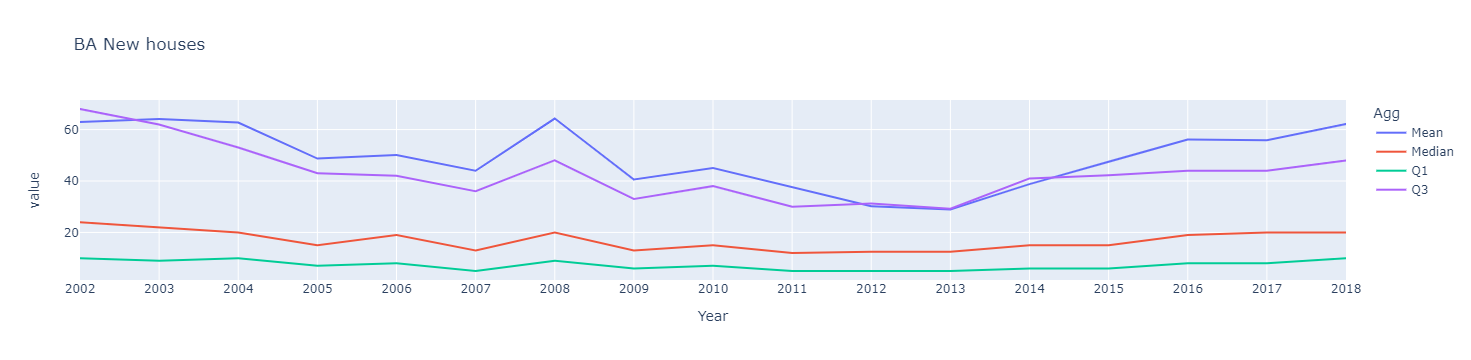

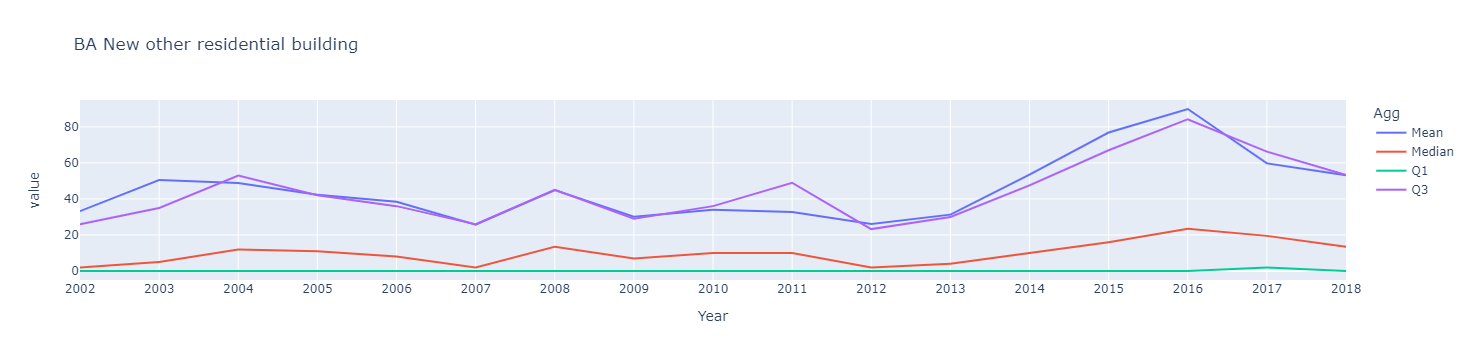

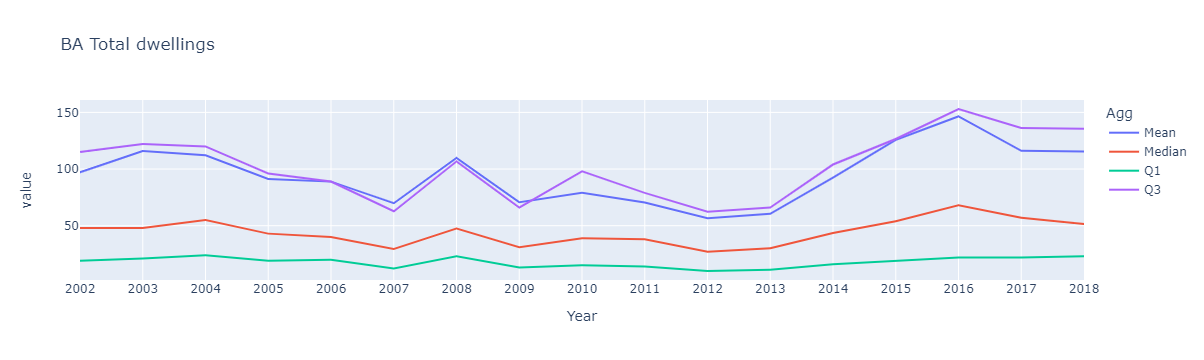

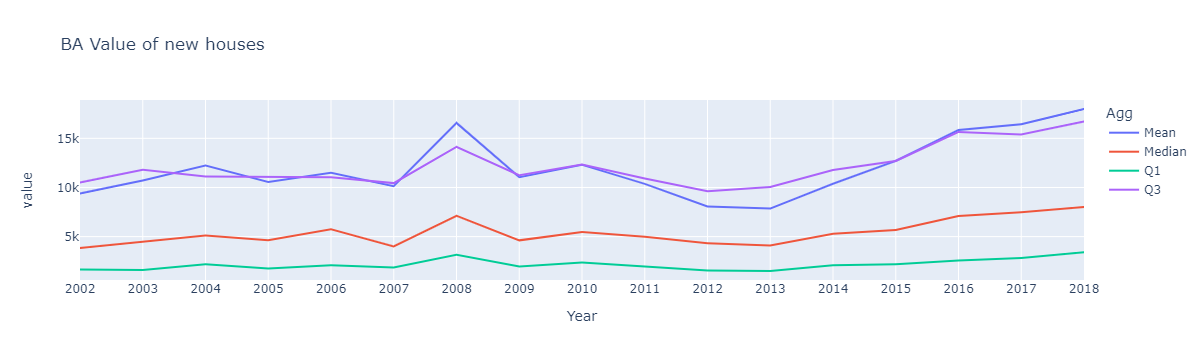

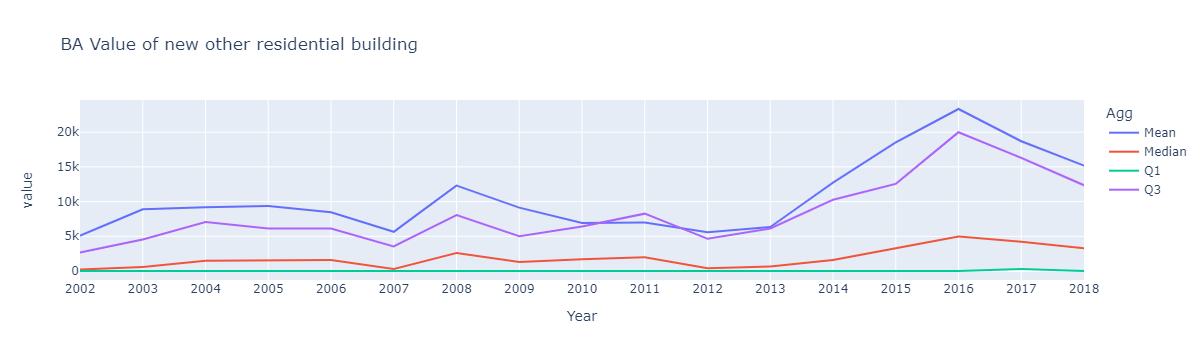

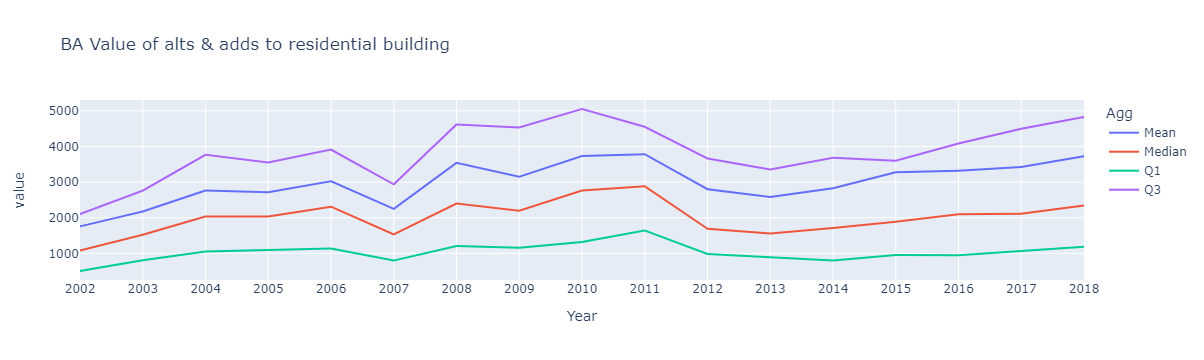

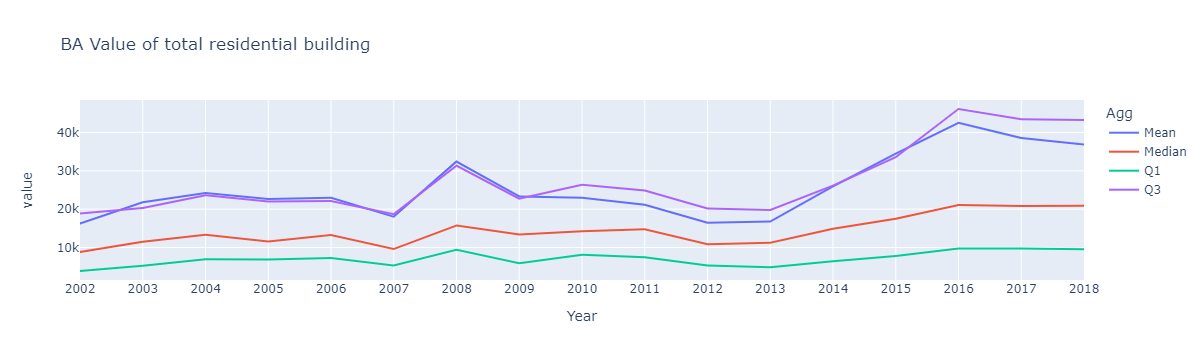

In [85]:
# Plot how Q1, median, Q3 and Mean has moved over time for Building Approvals
for col in df_time_agg.columns:
    if col not in ('Year', 'Agg'):
        chart = col
        df_plot = df_time_agg.pivot(index='Year', columns=agg_label)[col].reset_index()
        fig = px.line(df_plot, x="Year", y=df_plot.columns,
                      title=col)
        fig.update_xaxes(
            dtick="M1")
        fig.show()

In [78]:
df_time[df_time['ABS Code'] == 309071258]

,ABS Code,Year,BA New houses,BA New other residential building,BA Total dwellings,BA Value of new houses,BA Value of new other residential building,BA Value of alts & adds to residential building,BA Value of total residential building
239,309071258,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,309071258,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767,309071258,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1031,309071258,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1295,309071258,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1559,309071258,2007,486.0,172.0,658.0,102885.0,27227.3,808.4,130920.7
1823,309071258,2008,613.0,100.0,716.0,140724.2,19667.2,2270.3,162661.7
2087,309071258,2009,369.0,32.0,401.0,90524.6,6727.2,1896.0,99147.8
2351,309071258,2010,511.0,53.0,564.0,127716.9,9052.0,3027.3,139796.2
2615,309071258,2011,378.0,71.0,449.0,95053.8,10910.2,3582.5,109546.4


---

## Question 2

> Please give a description of any surprising findings or spurious factors that you believe may generalize poorly to new regions.

---

---

## Question 3

> Please provide any caveats (or “gotchas”) that you believe may undermine the power of any predictive model developed from these factors.

---

---

## Question 4

> Please outline any data you would wish to augment this dataset with to make a more powerful predictive model or any experiments you would propose to rule out spurious correlations.

---

Keep track of thoughts for later...

Some things that could be useful:

Financial data:
* Electricity prices over time
* Average wages by industry
* Distance to customer could be recorded as a 2d vector to enhance geometric understanding of this relationship

Demographic data:
* Election results
* Average building height?

Geographical data:
* Weather
* Altitude

Generally:
* More time points
* 

---